# Data Preparation

In [ ]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import seaborn as sns
import pandas as pd

# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_file = 'bert_no_FT.keras'

Keras = 3.8.0
Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Dataset

In [ ]:
import os
import pandas as pd

# Define the directory for saving the combined dataset
base_dir = "/content/drive/My Drive/SIT_Capstone/"
csv_file = os.path.join(base_dir, "combined_convo_dataset.csv")

# Define the paths for your datasets
splits = {
    'train': 'hf://datasets/BothBosu/scam-dialogue/scam-dialogue_train.csv',
    'test': 'hf://datasets/BothBosu/scam-dialogue/scam-dialogue_test.csv',
    'multi_agent_train': 'hf://datasets/BothBosu/multi-agent-scam-conversation/agent_conversation_train.csv',
    'multi_agent_test': 'hf://datasets/BothBosu/multi-agent-scam-conversation/agent_conversation_test.csv',
    'single_agent_train': 'hf://datasets/BothBosu/single-agent-scam-conversations/single-agent-scam-dialogue_train.csv',
    'single_agent_test': 'hf://datasets/BothBosu/single-agent-scam-conversations/single-agent-scam-dialogue_test.csv'
}
gen_convo_path = "hf://datasets/BothBosu/Scammer-Conversation/gen_conver_noIdentifier_1000.csv"

# Load datasets
try:
    train_df = pd.read_csv(splits['train'])
    test_df = pd.read_csv(splits['test'])
    multi_agent_train_df = pd.read_csv(splits['multi_agent_train'])
    multi_agent_test_df = pd.read_csv(splits['multi_agent_test'])
    single_agent_train_df = pd.read_csv(splits['single_agent_train'])
    single_agent_test_df = pd.read_csv(splits['single_agent_test'])
    gen_convo_df = pd.read_csv(gen_convo_path)

    # Standardize column naming
    for df in [train_df, test_df, multi_agent_train_df, multi_agent_test_df, single_agent_train_df, single_agent_test_df, gen_convo_df]:
        # Rename 'dialogue' or 'conversation' to 'conversation'
        if 'dialogue' in df.columns:
            df.rename(columns={'dialogue': 'conversation'}, inplace=True)
        elif 'conversation' not in df.columns:
            raise ValueError("Missing both 'dialogue' and 'conversation' columns in one of the datasets.")

        # Rename 'labels' to 'label' if present
        if 'labels' in df.columns:
            df.rename(columns={'labels': 'label'}, inplace=True)

    # Combine datasets into one
    combined_df = pd.concat([train_df, test_df, multi_agent_train_df, multi_agent_test_df, single_agent_train_df, single_agent_test_df, gen_convo_df], ignore_index=True)

    # Save the combined dataset
    combined_df.to_csv(csv_file, index=False)
    print("Combined dataset saved successfully!")

    # Print details
    print("First 5 rows of the combined dataset:")
    print(combined_df.head())

    # Total count of rows in the combined dataset
    total_count = len(combined_df)
    print(f"\nTotal number of rows in the combined dataset: {total_count}")

    # Count of each label
    if 'label' in combined_df.columns:
        label_counts = combined_df['label'].value_counts()
        print("Count of each label:")
        print(label_counts)
    else:
        print("Warning: No 'label' column found in the combined dataset.")

except Exception as e:
    print(f"An error occurred: {e}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Combined dataset saved successfully!
First 5 rows of the combined dataset:
                                        conversation type  label personality
0  caller: Hello, is this John? receiver: Yes, it...  ssn      1         NaN
1  caller: Hello, is this John? receiver: Yeah, t...  ssn      1         NaN
2  caller: Hello, is this Mr. Johnson? receiver: ...  ssn      1         NaN
3  caller: Hello, is this John? receiver: Yeah, t...  ssn      1         NaN
4  caller: Hello, this is Officer Johnson from th...  ssn      1         NaN

Total number of rows in the combined dataset: 5800
Count of each label:
label
1    2924
0    2876
Name: count, dtype: int64


# Data Cleaning

In [ ]:
# Remove duplicates
combined_df = combined_df.drop_duplicates()
print(f"Total rows after removing duplicates: {len(combined_df)}")

# Print new label_counts
label_counts = combined_df['label'].value_counts()
print(label_counts)

Total rows after removing duplicates: 5556
label
0    2839
1    2717
Name: count, dtype: int64


# Ratio of Normal to Fraud data Distribution

Ratio of normal to fraud: 0.91
Normal label percentage: 47.60%
Fraud label percentage: 52.40%


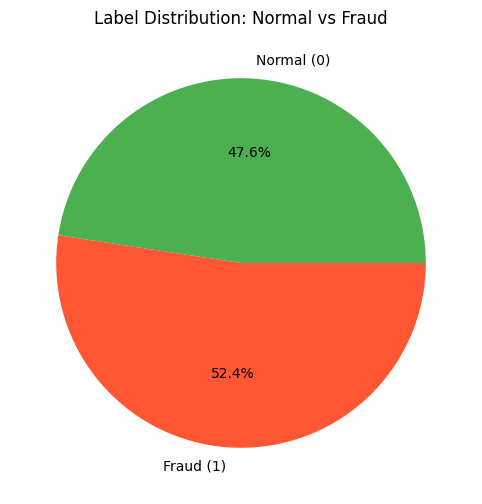

In [ ]:
# Count the occurrences of each label dynamically
label_counts = df['label'].value_counts().to_dict()

# Total number of entries
total_count = sum(label_counts.values())

# Extract counts for fraud (1) and normal (0) labels
normal_count = label_counts.get(0, 0)
fraud_count = label_counts.get(1, 0)

# Calculate the ratio of normal to fraud
if fraud_count > 0:  # Avoid division by zero
    ratio = normal_count / fraud_count
else:
    ratio = float('inf')  # If no fraud cases, set ratio to infinity

# Print the ratio and percentages
print(f"Ratio of normal to fraud: {ratio:.2f}")
print(f"Normal label percentage: {(normal_count / total_count) * 100:.2f}%")
print(f"Fraud label percentage: {(fraud_count / total_count) * 100:.2f}%")

# Visualize the label distribution as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    [normal_count, fraud_count],
    labels=['Normal (0)', 'Fraud (1)'],
    autopct='%1.1f%%',
    colors=['#4CAF50', '#FF5733']
)
plt.title('Label Distribution: Normal vs Fraud')
plt.show()

# Model Building

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Select only the required columns
X = combined_df['conversation']  # Features
y = combined_df['label']         # Target

# Split the dataset into training and testing sets with an 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data for BERT
def tokenize_texts(texts, tokenizer, max_length=256):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize training and testing data
print("Tokenizing training data...")
train_encodings = tokenize_texts(X_train, tokenizer)
print("Tokenizing testing data...")
test_encodings = tokenize_texts(X_test, tokenizer)

# Convert labels to torch tensors with float32 data type for binary classification
train_labels = torch.tensor(y_train.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.float32)

# Print the size of each split
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing training data...
Tokenizing testing data...
Training set size: 4444
Testing set size: 1112


# To check for optimal max length for tokenization

In [ ]:
avg_length = X.apply(lambda x: len(x.split())).mean()
print(f"Average text length: {avg_length}")

print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Testing label distribution:\n{y_test.value_counts()}")

Average text length: 316.81011519078476
Training label distribution:
label
0    2295
1    2149
Name: count, dtype: int64
Testing label distribution:
label
1    568
0    544
Name: count, dtype: int64


# Model Training (Bert)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, AdamW, get_scheduler, BertConfig
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Check device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Convert tokenized inputs into TensorDataset
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_labels
)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load the model with the modified configuration for binary classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define number of epochs
epochs = 10

# Define total training steps
num_training_steps = len(train_loader) * epochs

# Define warm-up steps (adjust if necessary, often 10% of total steps)
num_warmup_steps = int(0.1 * num_training_steps)

# Define scheduler
scheduler = get_scheduler(
    name="linear",  # Linear warm-up followed by linear decay
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Initialize history dictionary
history = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": []
}

# Early stopping configuration
best_val_loss = float("inf")
early_stopping_patience = 3
no_improvement_epochs = 0

model_checkpoint_path = "best_bert_no_finetune.pt"

# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}")
    model.train()

    # Initialize training loss and predictions
    train_loss = 0
    train_correct = 0
    train_total = 0
    progress_bar = tqdm(train_loader, desc="Training")

    for batch in progress_bar:
        # Move batch to device
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get logits and calculate binary cross entropy loss
        logits = outputs.logits.squeeze(-1)  # Squeeze to shape [batch_size]
        loss = torch.nn.BCEWithLogitsLoss()(logits, labels.float())
        train_loss += loss.item()

        # Predictions
        preds = (torch.sigmoid(logits) > 0.5).long()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step() # Update the learning rate
        optimizer.zero_grad()

    # Compute average training loss and accuracy
    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)

    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)

            # Compute validation loss
            loss = torch.nn.BCEWithLogitsLoss()(logits, labels.float())
            val_loss += loss.item()

            # Predictions
            batch_preds = (torch.sigmoid(logits) > 0.5).long()
            val_correct += (batch_preds == labels).sum().item()
            val_total += labels.size(0)

    # Compute average validation loss and accuracy
    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Checkpoint model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        torch.save(model.state_dict(), model_checkpoint_path)
        print("Model checkpoint saved.")
    else:
        no_improvement_epochs += 1

    # Early stopping
    if no_improvement_epochs >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Load the best model before evaluation
model.load_state_dict(torch.load(model_checkpoint_path))
print("Model training complete. Best model loaded.")

# Display training history
print("\nTraining History:")
print(history)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1


Training: 100%|██████████| 278/278 [03:17<00:00,  1.41it/s]


Training Loss: 0.3295, Training Accuracy: 0.8861


Validation: 100%|██████████| 70/70 [00:15<00:00,  4.44it/s]


Validation Loss: 0.0326, Validation Accuracy: 0.9982
Model checkpoint saved.

Epoch 2


Training: 100%|██████████| 278/278 [03:17<00:00,  1.41it/s]


Training Loss: 0.0190, Training Accuracy: 0.9982


Validation: 100%|██████████| 70/70 [00:15<00:00,  4.46it/s]


Validation Loss: 0.0043, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 3


Training: 100%|██████████| 278/278 [03:17<00:00,  1.41it/s]


Training Loss: 0.0036, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:15<00:00,  4.46it/s]


Validation Loss: 0.0020, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 4


Training: 100%|██████████| 278/278 [03:17<00:00,  1.41it/s]


Training Loss: 0.0020, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:15<00:00,  4.44it/s]


Validation Loss: 0.0013, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 5


Training: 100%|██████████| 278/278 [03:17<00:00,  1.40it/s]


Training Loss: 0.0014, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:15<00:00,  4.42it/s]


Validation Loss: 0.0009, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 6


Training: 100%|██████████| 278/278 [03:17<00:00,  1.40it/s]


Training Loss: 0.0011, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:15<00:00,  4.45it/s]


Validation Loss: 0.0007, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 7


Training: 100%|██████████| 278/278 [03:18<00:00,  1.40it/s]


Training Loss: 0.0009, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:15<00:00,  4.46it/s]


Validation Loss: 0.0006, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 8


Training: 100%|██████████| 278/278 [03:17<00:00,  1.41it/s]


Training Loss: 0.0008, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:15<00:00,  4.46it/s]


Validation Loss: 0.0006, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 9


Training: 100%|██████████| 278/278 [03:18<00:00,  1.40it/s]


Training Loss: 0.0007, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:15<00:00,  4.42it/s]


Validation Loss: 0.0005, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 10


Training: 100%|██████████| 278/278 [03:17<00:00,  1.41it/s]


Training Loss: 0.0007, Training Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:15<00:00,  4.44it/s]


Validation Loss: 0.0005, Validation Accuracy: 1.0000
Model checkpoint saved.


<ipython-input-9-d52d52c072e9>:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_checkpoint_path))


Model training complete. Best model loaded.

Training History:
{'train_loss': [0.3294720449250379, 0.0190445058359329, 0.0035653227576717948, 0.0020109126997588994, 0.0013651801344415964, 0.0010574593731342888, 0.0008666536545886812, 0.0007573605298145051, 0.000689758733878073, 0.0006556811142820034], 'val_loss': [0.03258456321699279, 0.004320463145683919, 0.0019883706666795273, 0.0012553500793209033, 0.0009217502233306212, 0.0007356872607488185, 0.0006243620649911463, 0.000553658400063536, 0.000514318621467932, 0.0005005145474569872], 'train_accuracy': [0.8861386138613861, 0.9981998199819982, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_accuracy': [0.9982014388489209, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


# Model Architecture

In [ ]:
# Print model architecture
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Plotting the Learning Curve of the Model

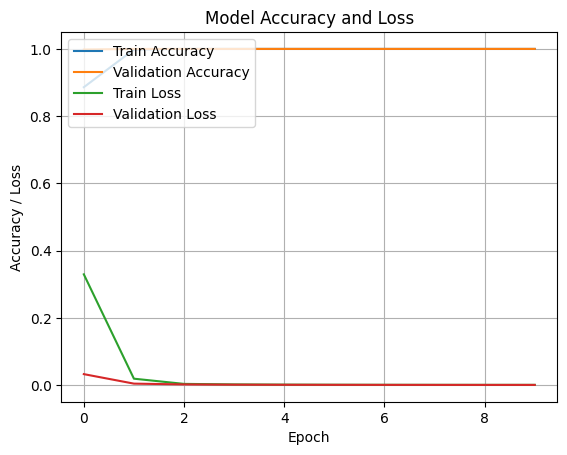

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')

# Plot Loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoch')

# Add legend
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)  # Optional for better readability
plt.show()

# Precision, Recall, F1-Score

In [ ]:
from sklearn.metrics import classification_report

# Set the model to evaluation mode
model.eval()

# Prepare the test data
test_encodings = tokenize_texts(X_test, tokenizer)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)  # Make sure labels are tensors
)

# DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)

        # Get the predicted probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())  # Move labels back to CPU for numpy operations
        predictions.extend(preds.cpu().numpy())   # Move predictions back to CPU for numpy operations

# Generate classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       544
         1.0       1.00      1.00      1.00       568

    accuracy                           1.00      1112
   macro avg       1.00      1.00      1.00      1112
weighted avg       1.00      1.00      1.00      1112



# Confusion Matrix

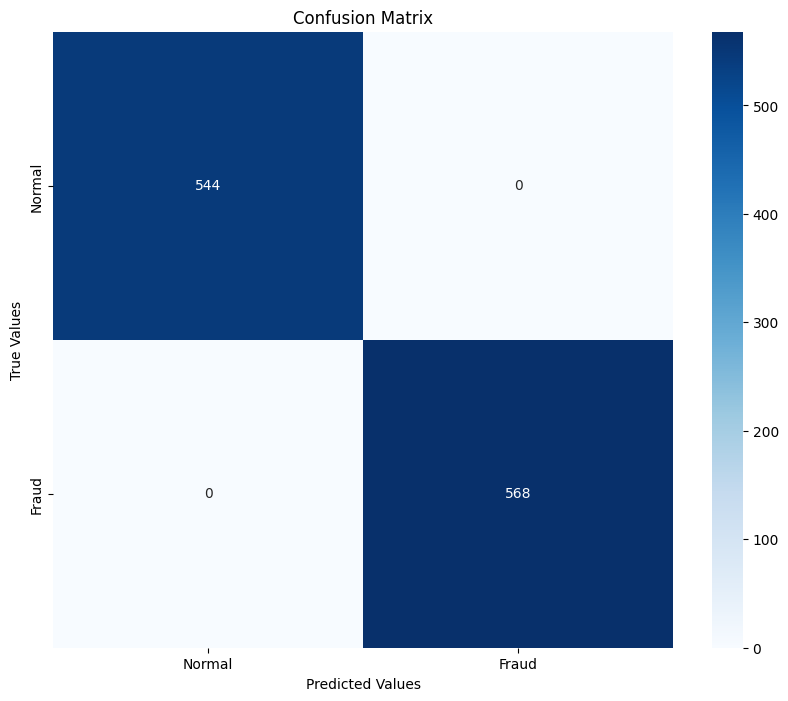

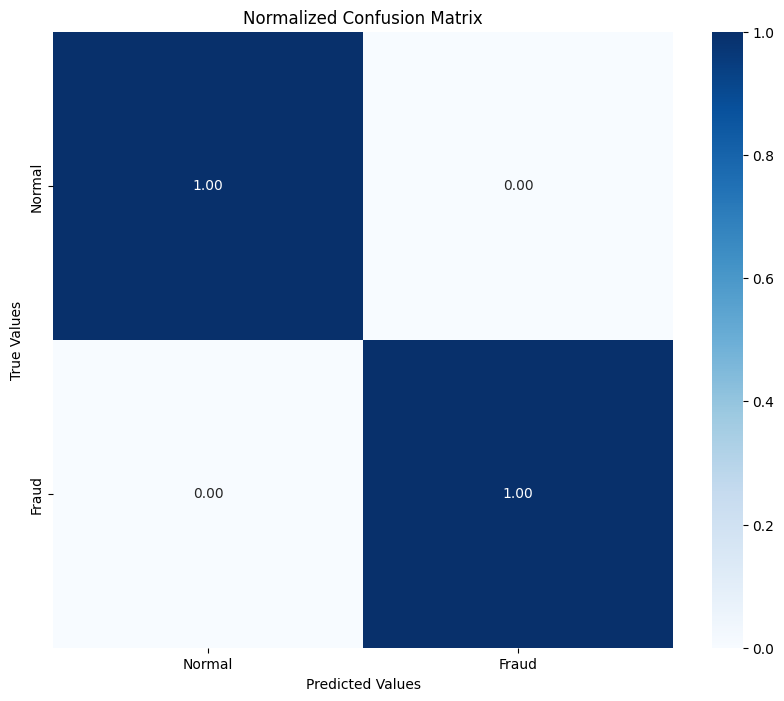

DSC: 1.0, Sensitivity: 1.0, Specificity: 1.0, Accuracy: 1.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch

def calculate_metrics(y_true, y_pred, classes=['Normal', 'Fraud']):
    """
    Calculate and display various evaluation metrics based on true and predicted labels.

    Parameters:
    - y_true: Array of true labels.
    - y_pred: Array of predicted labels.
    - classes: List of class labels (default: ['Normal', 'Fraud']).

    Returns:
    - dsc: Dice similarity coefficient (mean across classes).
    - sensitivity: Mean sensitivity across classes.
    - specificity: Mean specificity across classes.
    - accuracy: Overall accuracy.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Confusion Matrix')
    plt.show()

    # Normalize the confusion matrix by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate the Dice similarity coefficient (DSC) for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])

    # Calculate the sensitivity (recall) for each class and average them
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])

    # Calculate the specificity for each class and average them
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Calculate the overall accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Print the evaluation metrics
    print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

    return dsc, sensitivity, specificity, accuracy

# Make sure model is in evaluation mode
model.eval()

# Prepare the test data (tokenized input data for PyTorch)
test_encodings = tokenize_texts(X_test, tokenizer)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)  # Ensure labels are tensors
)

# DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)

        # Get the predicted probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())  # Move labels back to CPU for numpy operations
        predictions.extend(preds.cpu().numpy())   # Move predictions back to CPU for numpy operations

# Calculate metrics
dsc, sensitivity, specificity, accuracy = calculate_metrics(true_labels, predictions)
